# Experiment Results Visualization
This notebook visualizes the F1 scores from the `20k-hanna-data-sat` experiment, broken down by engineering method.

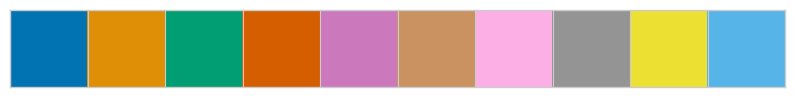

In [4]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Times"
plt.rcParams["font.weight"] = "light"

%matplotlib inline

import re
# establish and plot colorblind color pallete
colors = sns.color_palette('colorblind')
sns.set_palette(colors)
sns.palplot(colors)

In [1]:
import os
import glob
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_predictions_by_method():
    # Focus on the specific experiment directory
    search_path = '/home/maiwald/virus-engineer-detection/experiments/curated/20k-hanna-data-sat/*_predictions.csv'
    prediction_files = glob.glob(search_path, recursive=True)
    
    if not prediction_files:
        print(f"No prediction files found at {search_path}")
        return pd.DataFrame()

    results = []
    for file_path in prediction_files:
        try:
            # Extract method name from the filename
            filename = os.path.basename(file_path)
            method_part = filename.split('_', 2)[-1] # Remove timestamp
            method_name = method_part.replace('_predictions.csv', '')
            
            df = pd.read_csv(file_path)
            if 'true_label' not in df.columns or 'predicted_label' not in df.columns:
                print(f"Warning: {file_path} is missing required columns.")
                continue

            # 1. Calculate overall F1 score and count
            overall_score = f1_score(df['true_label'], df['predicted_label'])
            overall_count = df['true_label'].sum()
            results.append({
                'method': method_name,
                'metric': 'overall',
                'f1_score': overall_score,
                'positive_examples': overall_count
            })

            # 2. Calculate F1 score and count per engineering_method
            if 'engineering_method' in df.columns:
                for eng_method in df['engineering_method'].unique():
                    subset_df = df[df['engineering_method'] == eng_method]
                    if len(subset_df) > 0:
                        score = f1_score(subset_df['true_label'], subset_df['predicted_label'], zero_division=0)
                        count = subset_df['true_label'].sum()
                        results.append({
                            'method': method_name,
                            'metric': eng_method,
                            'f1_score': score,
                            'positive_examples': count
                        })
            else:
                print(f"Warning: 'engineering_method' column not found in {file_path}")

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            
    return pd.DataFrame(results)

results_df = analyze_predictions_by_method()
display(results_df)

,method,metric,f1_score,positive_examples
0,kmer,overall,0.064777,80
1,kmer,natural,0.000000,0
2,kmer,region_inversion,0.250000,7
3,kmer,gfp_insertion,0.300000,17
4,kmer,region_duplication,0.181818,10
5,kmer,igem_gfp_insertion,0.100000,19
6,kmer,tn5_insertion,0.307692,11
7,kmer,crispr_insertion,0.000000,13
8,kmer,random_substitution,0.000000,3
9,blast,overall,0.048148,80


/home/maiwald/virus-engineer-detection/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/maiwald/virus-engineer-detection/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/maiwald/virus-engineer-detection/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/maiwald/virus-engineer-detection/.venv/lib/pyt

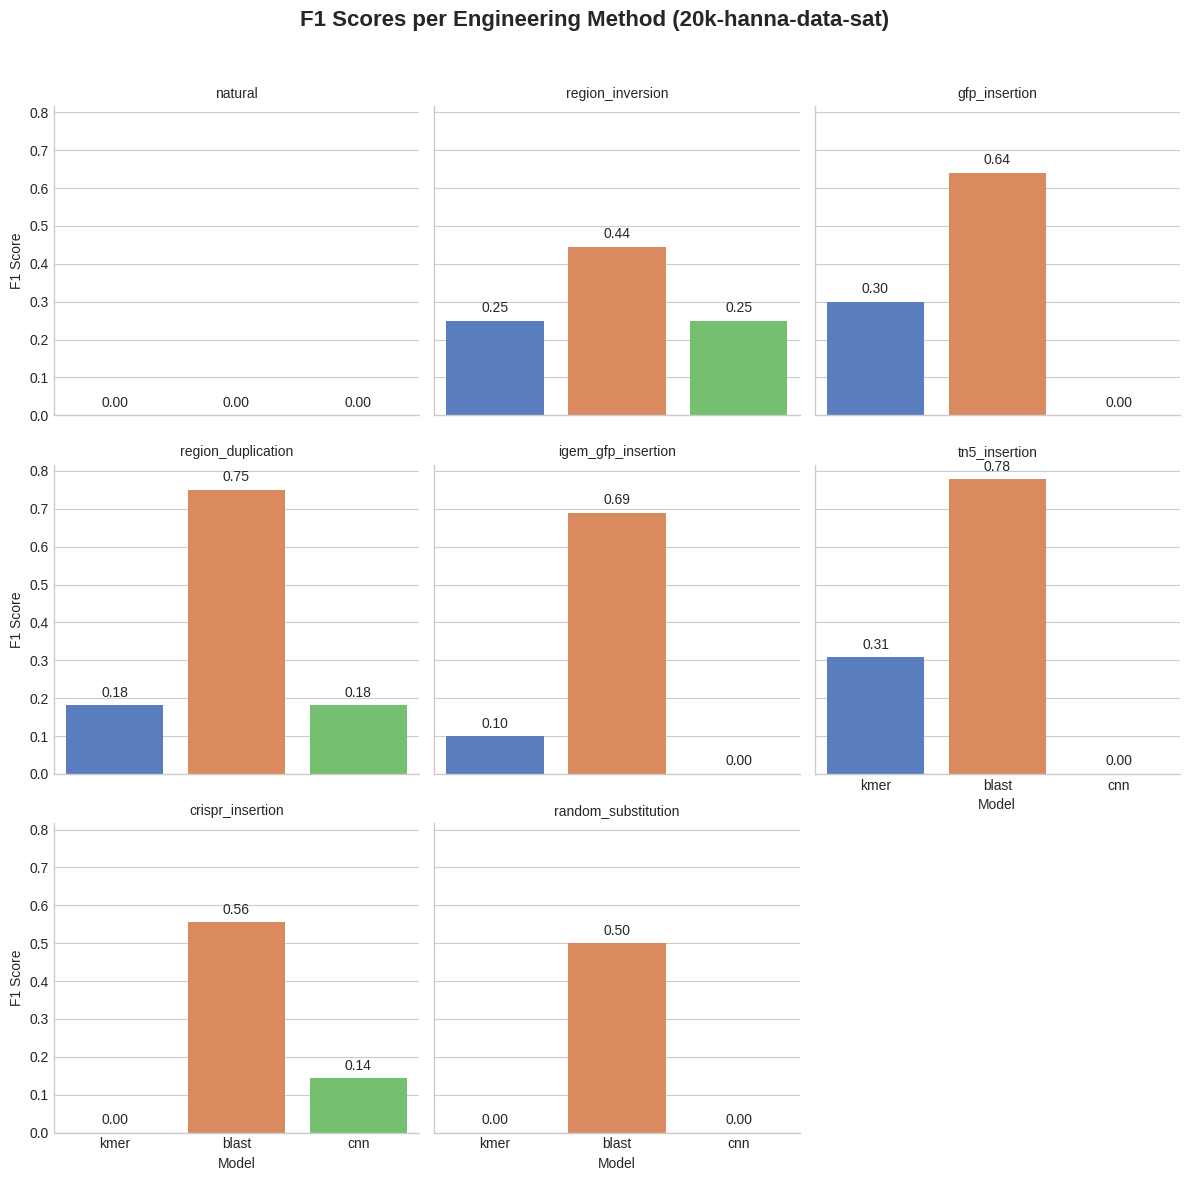

In [5]:
if not results_df.empty:
    # Exclude 'overall' from engineering methods
    eng_df = results_df[results_df['metric'] != 'overall'].copy()
    plt.style.use('seaborn-v0_8-whitegrid')
    
    g = sns.FacetGrid(eng_df, col='metric', col_wrap=3, height=4, sharey=True)
    g.map_dataframe(sns.barplot, x='method', y='f1_score', palette='muted')
    
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Model", "F1 Score")
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('F1 Scores per Engineering Method (20k-hanna-data-sat)', fontsize=16, weight='bold')
    plt.show()
else:
    print("DataFrame is empty. No plot to generate.")
